# Advanced Machine Learning - Classification Midterm Project

This notebook aims at analyzing and performing classification tasks on the Fashion MNIST and sklearn digits datasets. Every task will be divided into smaller subtasks, in order to maintain readability and have a clear development structure

- **Student: Georgiy Farina (georgiy.farina@student.supsi.ch)**
- **Teacher: Loris Cannelli (loris.cannelli@supsi.ch)**
- **Start Date: 09.11.2023**
- **End Date: 19.11.2023**

## Task 0
Importing necessary libraries for data loading, models creation/training/evaluation and visualizing various plots

In [1]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

from keras.callbacks import Callback


## Task 1: Use the tool you prefer (e.g., LDA, t-SNE) to perform a preliminary visualization of the two datasets.

A quick look at the dataset of the sklearn digits. All images have shape 8x8

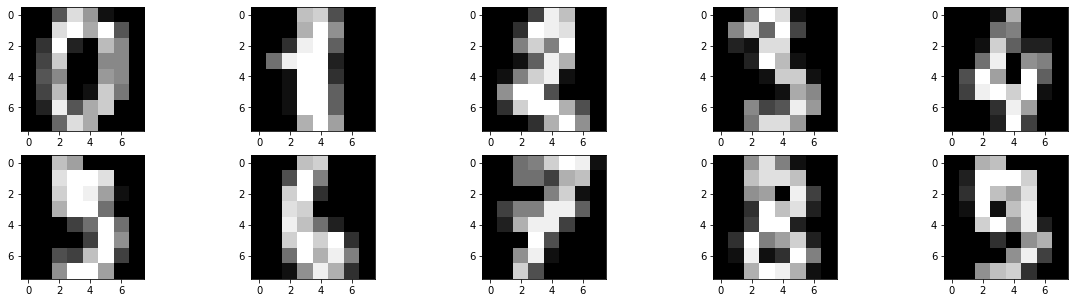

In [2]:
digits = load_digits()
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 5))
for i in range(5):
    axes[0, i].imshow(digits.images[i], cmap='gray')
    axes[1, i].imshow(digits.images[i+5], cmap='gray')

For future modelling with Neural Networks, i normalized the data for it to be all in the same 0-1 range

In [3]:
digits_data = digits.data
digits_target = digits.target
d_min, d_max = np.min(digits_data), np.max(digits_data)
print(f"Digits dataset: before normalization pixel values range from {d_min} to {d_max}")

digits_data = digits_data / d_max
d_min, d_max = np.min(digits_data), np.max(digits_data)
print(f"Digits dataset: after normalization, pixel values ranging from {d_min} to {d_max}")

Digits dataset: before normalization pixel values range from 0.0 to 16.0
Digits dataset: after normalization, pixel values ranging from 0.0 to 1.0


After normalization, pass the data to the TSNE model for visualization purposes

In [4]:
tsne_digits = TSNE(n_components=2, random_state=24)
digits_2d = tsne_digits.fit_transform(digits_data)

C:\Users\georg\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\georg\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


After the digits dataset, i did the same procedure on the MNIST Fashion dataset

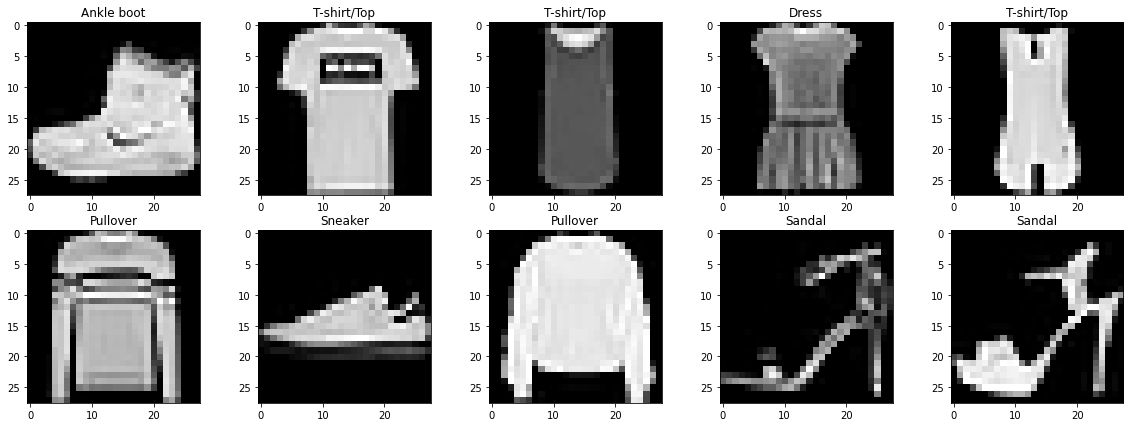

In [5]:
(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels)= fashion_mnist.load_data()
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 7))
labels_mappings = {0: "T-shirt/Top", 1:"Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
for i in range(5):
    axes[0, i].imshow(fashion_train_images[i], cmap='gray')
    axes[0, i].set_title(labels_mappings[fashion_train_labels[i]])
    axes[1, i].imshow(fashion_train_images[i+5], cmap='gray')
    axes[1, i].set_title(labels_mappings[fashion_train_labels[i+5]])

In [6]:
f_min, f_max = np.min(fashion_train_images), np.max(fashion_train_images)

print(f"Fashion dataset: before normalization pixel values range from {f_min} to {f_max}")

fashion_train_images = fashion_train_images / f_max
fashion_test_images = fashion_test_images / f_max
f_min, f_max = np.min(fashion_train_images), np.max(fashion_train_images)

print(f"Fashion dataset: before normalization pixel values range from {f_min} to {f_max}")

Fashion dataset: before normalization pixel values range from 0 to 255
Fashion dataset: before normalization pixel values range from 0.0 to 1.0


In [7]:
fashion_data = np.concatenate((fashion_train_images.reshape(-1, 28*28), fashion_test_images.reshape(-1, 28*28)), axis=0)
fashion_target = np.concatenate((fashion_train_labels, fashion_test_labels), axis=0)
tsne_fashion = TSNE(n_components=2, random_state=0)
fashion_2d = tsne_fashion.fit_transform(fashion_data)

C:\Users\georg\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\georg\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [8]:
print(fashion_data.shape, fashion_target.shape)

(70000, 784) (70000,)


Below you can see the result of the T-SNE clustering, which shows how far or close are the digits and the fashion items between each other. The digits are more distinct and easily separable, whereas the fashion items are more mixed and easily confusable. From this preliminary visualization we could assume that further along we might get a model for the digits dataset that is more efficient than the one for the fashion items.

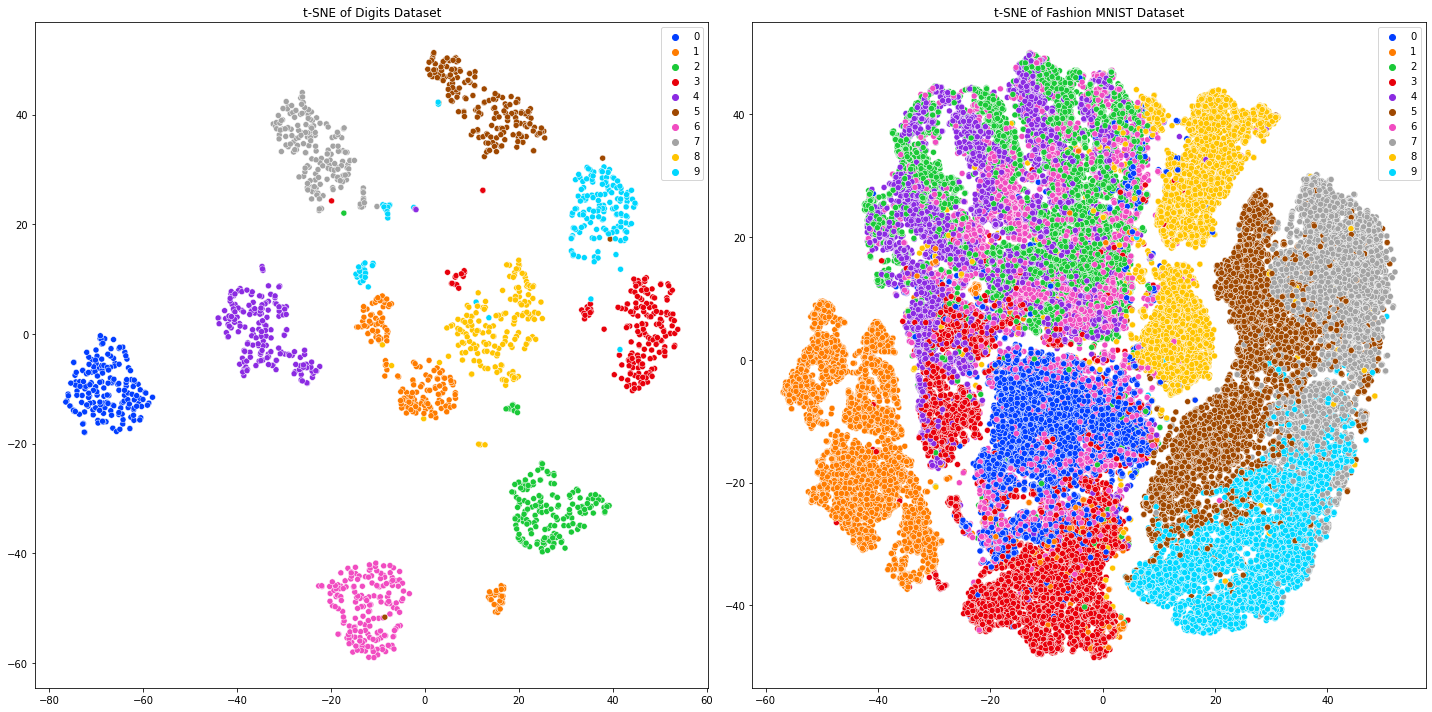

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
sns.scatterplot(x=digits_2d[:, 0], y=digits_2d[:, 1], hue=digits_target, palette=sns.color_palette("bright", 10), legend='full', ax=ax[0])
ax[0].set_title('t-SNE of Digits Dataset')

sns.scatterplot(x=fashion_2d[:, 0], y=fashion_2d[:, 1], hue=fashion_target, palette=sns.color_palette("bright", 10), legend='full', ax=ax[1])
ax[1].set_title('t-SNE of Fashion MNIST Dataset')

plt.tight_layout()
plt.show()

## Task 2: Run a multilayer perceptron with two hidden layers and rectified nonlinearities on the digits dataset from sklearn using the tensorflow.keras Sequential interface. Include code for selecting _l2_-norm regularization strength and number of hidden units using GridSearchCV and evaluation on an independent test-set.

First i split the digits data into X and Y, train and test, with a size split of 75/25

In [10]:
X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(digits_data, digits_target, test_size=0.25, random_state=24)

Then, i created a function that accepts as parameters the hidden layers sizes and the L2 regularization strength, and a personalized class called HistoryCallback that keeps track of the loss on the training and validation sets

In [11]:
def create_model(hidden_layer_sizes=(128,128), l2_reg=0.01):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], input_dim=64, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(hidden_layer_sizes[1], activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(10, activation='softmax')) # 10 because of the 10 digits as possible outputs
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

class HistoryCallback(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
    
model = KerasClassifier(build_fn=create_model, verbose=0, callbacks=[HistoryCallback()])

C:\Users\georg\AppData\Local\Temp/ipykernel_30956/1113049003.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0, callbacks=[HistoryCallback()])


Now, with the model being defined as above, i implemented the following code that fits the model for the different parameter values, Once the models are fit, the plots are being made, from which certain assumption could be made:
- The higher the L2 regularization strength is, the lower the final F2 score is and the steeper the decrease in initial loss is
- Also, with higher L2, the validation loss seems to be exactly the same as the training loss. Whereas, having a very little L2 penalty, makes a little gap between validation and training. This might lead to overfitting
- With higher layer sizes the model can pick up complex patterns, but it needs to be appropriately regularized.

For the above reasons, the best combination that i found is to have a high number of nodes in the hidden layers (1024, 1024(, but also to keep a very low L2 regularization (0.001)

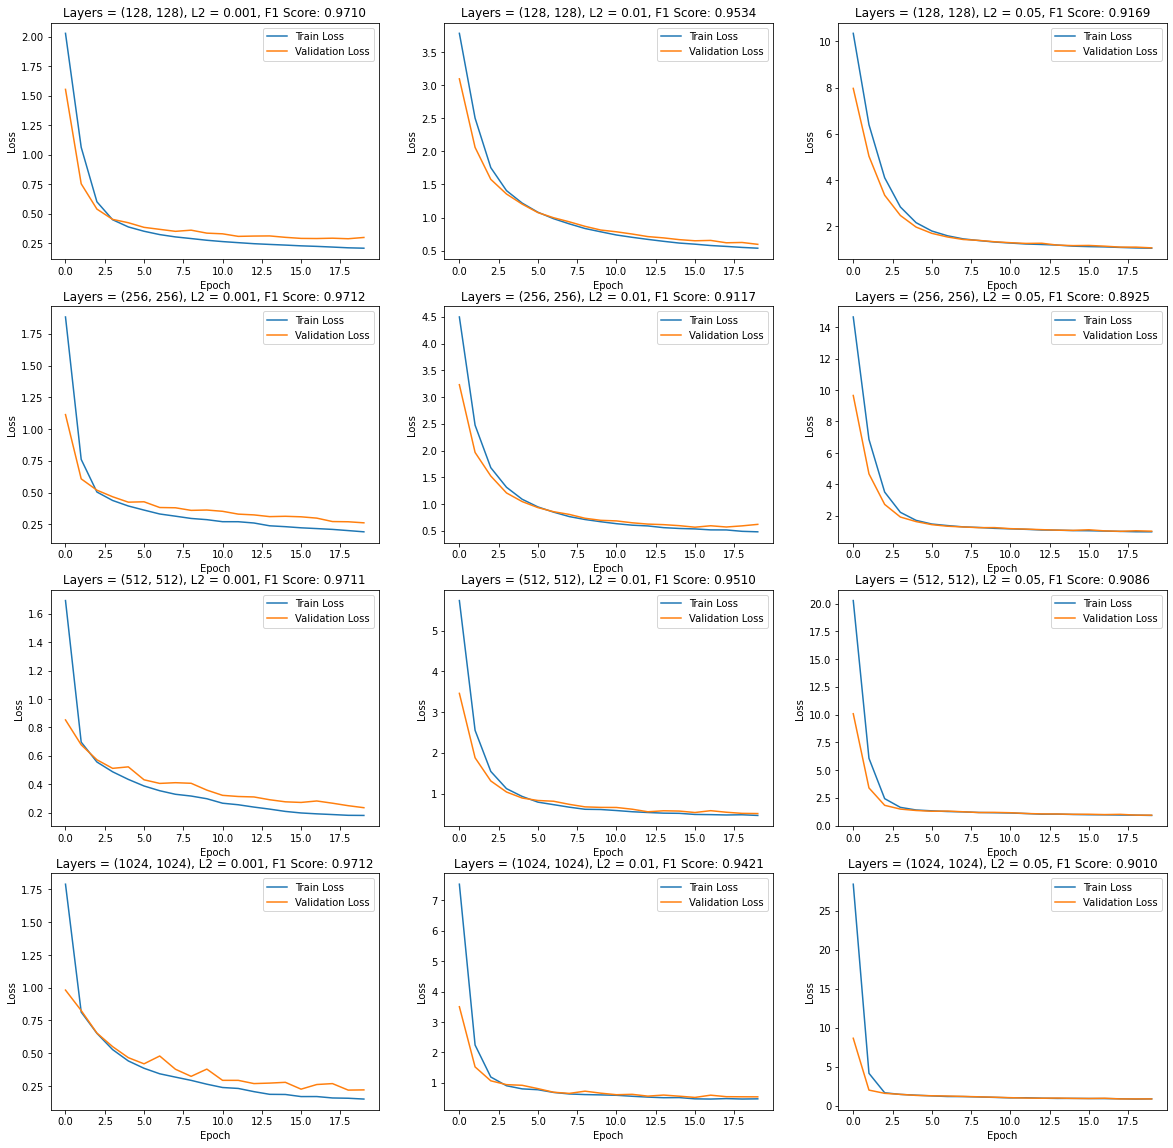

In [12]:
param_grid = {
    'hidden_layer_sizes': [(128, 128), (256, 256), (512, 512), (1024, 1024)],
    'l2_reg': [0.001, 0.01, 0.05]
}

fig, axes = plt.subplots(nrows=len(param_grid['hidden_layer_sizes']), ncols=len(param_grid['l2_reg']), figsize=(20, 20))

best_accuracy = 0
best_model = None
best_hidden_layers = None
best_l2 = None

for i, hidden_layers in enumerate(param_grid['hidden_layer_sizes']):
    for j, l2_reg in enumerate(param_grid['l2_reg']):
        model = create_model(hidden_layer_sizes=hidden_layers, l2_reg=l2_reg)
        history = model.fit(X_train_digits, y_train_digits, validation_split=0.25, epochs=20, verbose=0)
        
        y_pred = model.predict(X_test_digits, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        f1 = f1_score(y_test_digits, y_pred_classes, average='weighted')
        accuracy = accuracy_score(y_test_digits, y_pred_classes)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_l2 = l2_reg
            best_hidden_layers = hidden_layers
        
        axes[i, j].plot(history.history['loss'], label='Train Loss')
        axes[i, j].plot(history.history['val_loss'], label='Validation Loss')

        axes[i, j].set_title(f'Layers = {hidden_layers}, L2 = {l2_reg}, F1 Score: {f1:.4f}')
        axes[i, j].set_ylabel('Loss')
        axes[i, j].set_xlabel('Epoch')
        axes[i, j].legend()

After having compiled a new model for each of the combinations, based on the best value of the F1 score, the best parameters i obtained were (1024, 1024) for hidden layer sizes and 0.001 for the L2 penalty.

In [13]:
y_train_pred = best_model.predict(X_train_digits)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

y_test_pred = best_model.predict(X_test_digits)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

train_accuracy = accuracy_score(y_train_digits, y_train_pred_classes)
test_accuracy = accuracy_score(y_test_digits, y_test_pred_classes)

train_confusion_matrix = confusion_matrix(y_train_digits, y_train_pred_classes)
test_confusion_matrix = confusion_matrix(y_test_digits, y_test_pred_classes)

train_f1 = f1_score(y_train_digits, y_train_pred_classes, average='weighted')
test_f1 = f1_score(y_test_digits, y_test_pred_classes, average='weighted')

print('Train set accuracy:', train_accuracy)
print('Test set accuracy:', test_accuracy)
print('Train set F1 score:', train_f1)
print('Test set F1 score:', test_f1) 

15/15 [==============================] - 0s 2ms/step
Train set accuracy: 0.9851521900519673
Test set accuracy: 0.9711111111111111
Train set F1 score: 0.9851632512264893
Test set F1 score: 0.9710134167868086


To better visualize the efficiency of the model, i plot the two confusion matrices for Training and Testing sets. As can be seen, the model predicts correctly almost all of the samples.

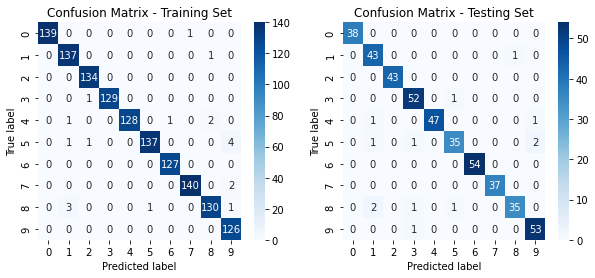

In [14]:
def plot_cm(cm, title, axis = None):
    if axis is None:
        fig, axis = plt.subplots(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axis)
    axis.set_title(title)
    axis.set_ylabel('True label')
    axis.set_xlabel('Predicted label')

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
plot_cm(train_confusion_matrix, "Confusion Matrix - Training Set", axis=ax[0])
plot_cm(test_confusion_matrix, "Confusion Matrix - Testing Set", axis=ax[1])

### Bonus points: _Transfer learning_ - Reuse an existing architecture and pre-traine weights from keras (https://keras.io/api/applications/). Compare retraining only the densely connected layers with fine-tuning the whole network

## Task 3: Train a multilayer perceptron (fully connected) on the Fashion MNIST dataset using the traditional train/test split as given by fashion_mnist.load_data in tensorflow.keras. Use a separate 10000 samples (from the training set) for model selection and to compute learning curves (accuracy vs epochs, not accuracy vs n_samples). Compare a "vanilla" model with a model using a drop-out and evaluate if using drop-out allows you to learn a bigger network. Then, compare to a model using batch normalization. Visualize learning curves for all models.

First i picked the last 10000 samples from the training set as validation, and the remaining as train

In [15]:
fashion_train_images = fashion_train_images.reshape((fashion_train_images.shape[0], -1))
fashion_test_images = fashion_test_images.reshape((fashion_test_images.shape[0], -1))

X_train_fashion, X_val_fashion = fashion_train_images[:-10000], fashion_train_images[-10000:]
y_train_fashion, y_val_fashion = fashion_train_labels[:-10000], fashion_train_labels[-10000:]

Then i created 3 separate functions which purpose is to create the 3 types of models: Vanilla, Dropout and BatchNormalization. These functions rely on the best parameters i've already gotten earlier during the tuning of layer sizes and l2 regularization. There is also a separate function that, given the train/val splits and the model, fits the latter and returns its history of training

In [16]:
def vanilla_model(input_dim=784):
    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    model.add(Dense(best_hidden_layers[0], activation='relu', kernel_regularizer=l2(best_l2)))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def dropout_model(input_dim=784, dropout_rate=0.5):
    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    model.add(Dense(best_hidden_layers[0], activation='relu', kernel_regularizer=l2(best_l2)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def batchnorm_model(input_dim=784):
    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(Dense(best_hidden_layers[0], activation='relu', kernel_regularizer=l2(best_l2)))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def compile_train(model, X_train, y_train, X_val, y_val):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=256,
                        validation_data=(X_val, y_val),
                        verbose=0) 
    return history
    

Here the 3 histories lists are defined with the help of the previously defined function

In [17]:
vanilla = vanilla_model()
dropout = dropout_model()
batchnorm = batchnorm_model()

vanilla_history = compile_train(
    vanilla, 
    X_train_fashion, 
    y_train_fashion, 
    X_val_fashion, 
    y_val_fashion
)

dropout_history = compile_train(
    dropout, 
    X_train_fashion, 
    y_train_fashion, 
    X_val_fashion, 
    y_val_fashion
)
batchnorm_history = compile_train(
    batchnorm, 
    X_train_fashion, 
    y_train_fashion,
    X_val_fashion, 
    y_val_fashion
)

Here below there are plots representing the history of epochs training and the accuracy of the model. What can be said from these plots is:
- All 3 models are able to achieve good results in terms of accuracy
- Vanilla and BatchNormalization models indicate some overfitting due the gap between the plateaues of train and validation scores
- Vanilla model is constantly growing in accuracy with the number of epochs, suggesting its efficiency in learning from the data
- Dropout model's plot of accuracy might indicate its inability to capture all patterns in the data, due to the validation score plateauing earlier than the train one

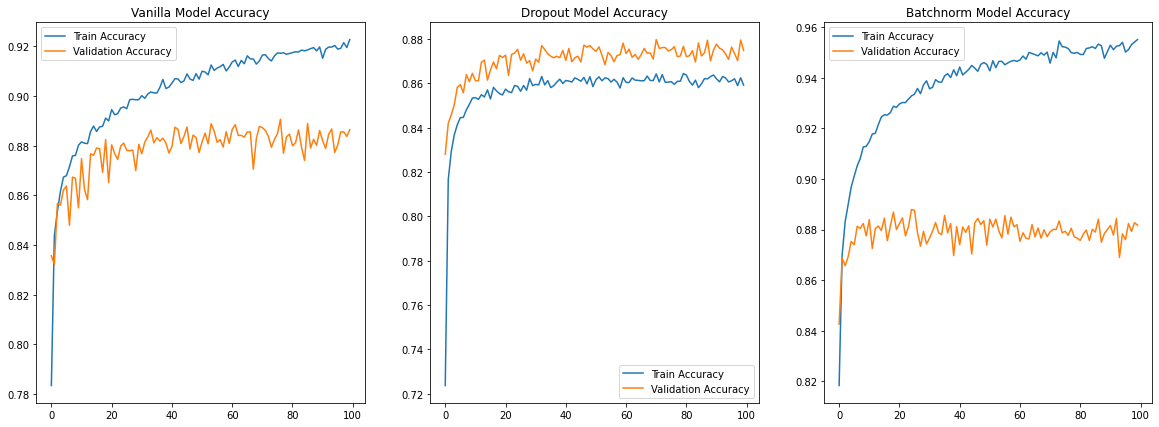

In [18]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 7))

ax[0].plot(vanilla_history.history['accuracy'], label='Train Accuracy')
ax[0].plot(vanilla_history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Vanilla Model Accuracy')
ax[0].legend()

ax[1].plot(dropout_history.history['accuracy'], label='Train Accuracy')
ax[1].plot(dropout_history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Dropout Model Accuracy')
ax[1].legend()


ax[2].plot(batchnorm_history.history['accuracy'], label='Train Accuracy')
ax[2].plot(batchnorm_history.history['val_accuracy'], label='Validation Accuracy')
ax[2].set_title('Batchnorm Model Accuracy')
ax[2].legend()

## Task 4: Perform calibration on one of the previously implemented models of your choice. Plot the Reliability Diagram before and after the calibration procedure.

Firstly i plot the Reliability Diagram of the Dropout model before calibration, with mean predicted probability VS fraction of positive classes, for a specific class, in this case 0. 

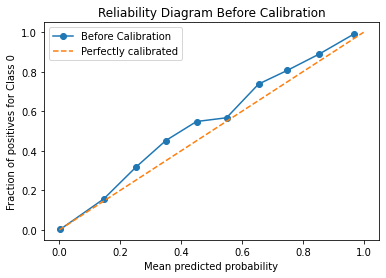

In [19]:
y_probs_before = dropout.predict(X_val_fashion, verbose=0)

class_index = 0
y_true_binary = (y_val_fashion == class_index).astype(int)
y_probs_class_0_before = y_probs_before[:, class_index]

prob_true_before, prob_pred_before = calibration_curve(y_true_binary, y_probs_class_0_before, n_bins=10)

plt.plot(prob_pred_before, prob_true_before, marker='o', label='Before Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel(f'Fraction of positives for Class {class_index}')
plt.title('Reliability Diagram Before Calibration')
plt.legend()
plt.show()

Then, i performed calibration using CalibratedClassifierCV, to which i pass my dropout model. Once trained, i obtained the calibrated labels probabilities

In [20]:
dropout_model = KerasClassifier(model=dropout, epochs=100, batch_size=256, verbose=0)
dropout_model.fit(X_train_fashion, y_train_fashion)

calibrated_model = CalibratedClassifierCV(dropout_model, cv='prefit', method='sigmoid')
calibrated_model.fit(X_val_fashion, y_val_fashion)

y_probs_calibrated = calibrated_model.predict_proba(X_val_fashion)

At last, for every index in the dataset, i plot the Reliability Diagram with different colors. From the plot it can be seen that in both the beginning and end of the plots (mean predicted probability < 0.2 or > 0.8) the lines are pretty close to a perfectly calibrated model, whereas in the middle region its spread out in many directions

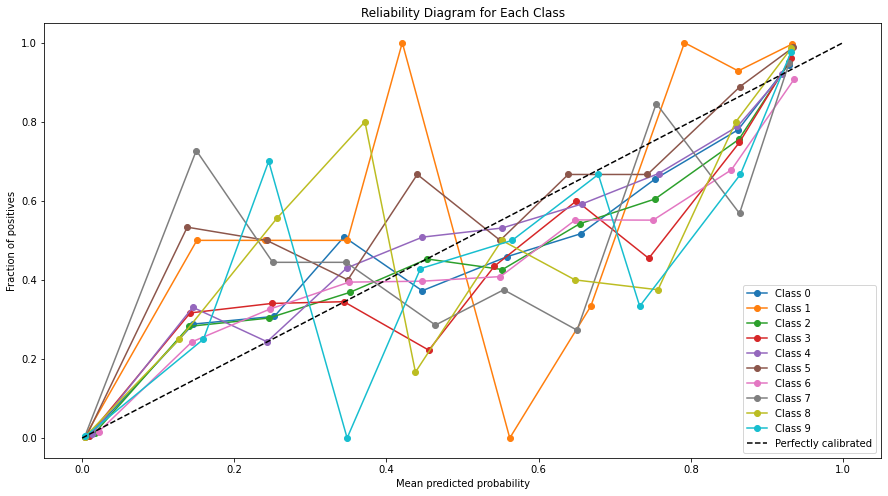

In [23]:
plt.figure(figsize=(15, 8))
for class_index in range(y_probs_calibrated.shape[1]):
    y_true_binary = (y_val_fashion == class_index).astype(int)
    y_probs_binary = y_probs_calibrated[:, class_index]

    fraction_of_positives, mean_predicted_value = calibration_curve(y_true_binary, y_probs_binary, n_bins=10)

    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f'Class {class_index}')

plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram for Each Class')
plt.legend()
plt.show()